In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import suppression as s
import utils
import linear_model as model

In [4]:
gaba_fn = 'gaba_data.txt'
supp_fn = 'supp_data_individual_20170427.txt'

In [5]:
sdf = utils.load_psychophys(supp_fn)
gdf = utils.load_gaba(gaba_fn)

In [6]:
plot_dir = "plots/redo-201807"

## Analyze tasks separately (before subsetting to include common subjects)##

In [7]:
pp_subjs = np.unique(sdf.Subject)
gaba_subjs = np.unique(gdf.subjName)
print(pp_subjs, len(pp_subjs))
print(gaba_subjs, len(gaba_subjs))

['ah' 'ai' 'am' 'ap' 'bi' 'bo' 'cl' 'cr' 'ct' 'dl' 'ds' 'eg' 'ei' 'em' 'es'
 'gd' 'gm' 'gw' 'jd' 'jv' 'ke' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'mv' 'nl' 'nn'
 'rn' 'sd' 'se' 'tj' 'tm' 'tt' 'yl'] 37
['ac' 'ai' 'am' 'as' 'bi' 'ch' 'cr' 'cs' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm'
 'jd' 'jm' 'jv' 'ks' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'ps' 'rn' 'sd' 'tt'
 'yl'] 31


### GABA only analyses

### GABA t-test, CON v AMB

In [8]:
pop_group = gdf.groupby("Population")
pop_group.describe()

GABA                                                           
           count      mean       std    min     25%     50%      75%    max
Population                                                                 
Amblyope    16.0  0.202312  0.013385  0.179  0.1925  0.2025  0.21125  0.227
Control     15.0  0.206333  0.016482  0.173  0.1925  0.2110  0.21650  0.228

In [9]:
gaba_per_group = [col for col_name, col in pop_group['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group)
print(tstat, pval)

-0.747810754413 0.460595837907


### GABA violin plot, n=31 (all)

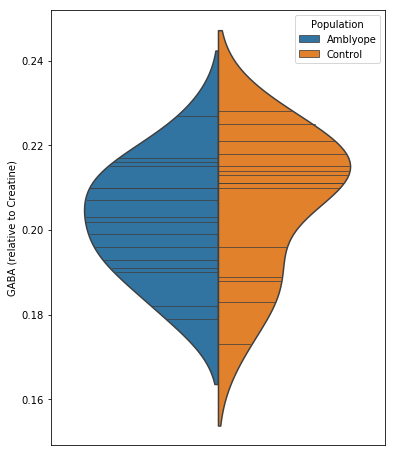

In [10]:
with s.PdfPages(f"{plot_dir}/gaba_diffs_n31.pdf") as pdf:
    fig = plt.figure(figsize=(6,8))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    ax = sns.violinplot(y='GABA',x='Presentation',hue='Population',data=gdf,split=True,inner='stick',ax=ax)
    ax.xaxis.set_visible(False)
    ax.set_ylabel("GABA (relative to Creatine)")
    plt.show(ax.figure)
    pdf.savefig(ax.figure)
    plt.close(ax.figure)
    plt.close('all')

## Select one psychophysical task's data ##

In [11]:
task = 'SS'
sdf = sdf[sdf['Task']==task]

### Begin grouping data into conditions to model Subject's ThreshElev as a function of logRelContrast #

In [12]:
pp_gvars = ['Task','Orientation','Presentation','Population','Subject','Eye','Trace'] # One condition
pp_gvars_base = pp_gvars + ['BaselineThresh']

In [13]:
# create groups based on these grouping variables
groups = sdf.groupby(pp_gvars)
print(len(groups))
#for gv, g in groups:
#    print(gv)

256


### Find the RelMaskContrast at which NDE and DE most different within population using t-tests

In [14]:
tt_df = sdf

In [15]:
tt_df.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811


In [16]:
gvars_ttest = ['Task','Orientation','Presentation','Population']
gvars_pair = gvars_ttest + ['BinNumber']

tt_grouped = tt_df.groupby(gvars_ttest)
print(len(tt_grouped))

for gv, g in tt_grouped:
    print(gv)

8
('SS', 'Cross', 'nDicho', 'Amblyope')
('SS', 'Cross', 'nDicho', 'Control')
('SS', 'Cross', 'nMono', 'Amblyope')
('SS', 'Cross', 'nMono', 'Control')
('SS', 'Iso', 'nDicho', 'Amblyope')
('SS', 'Iso', 'nDicho', 'Control')
('SS', 'Iso', 'nMono', 'Amblyope')
('SS', 'Iso', 'nMono', 'Control')


In [17]:
tt_ind_binpred = tt_grouped.apply(utils.test_all_bins, gvars_pair, st.ttest_ind).reset_index()

('SS', 'Cross', 'nDicho', 'Amblyope', 1)
0.792
[ 1.921  1.434  0.805  1.043]
[ 0.947  1.026  0.807]
('SS', 'Cross', 'nDicho', 'Amblyope', 1)
0.792
[ 1.921  1.434  0.805  1.043]
[ 0.947  1.026  0.807]
('SS', 'Cross', 'nDicho', 'Amblyope', 2)
1.432
[ 1.23   1.056  1.057  2.058  1.112  1.755  0.888  1.296  1.229  1.076]
[ 0.859  0.542  0.98   0.642]
('SS', 'Cross', 'nDicho', 'Amblyope', 3)
2.604
[ 1.629  1.378  2.68   0.989  3.318  1.007  1.459  0.68   1.555  1.14 ]
[ 0.505  1.014  1.093  0.759  0.964  0.867  1.099  1.177  0.718]
('SS', 'Cross', 'nDicho', 'Amblyope', 4)
4.526
[ 1.783  1.275  1.585  4.893  1.056  1.195  1.369  1.222  1.337]
[ 0.689  0.553  0.935  0.99   1.22   0.617  1.125  1.17   0.76   0.591
  0.685]
('SS', 'Cross', 'nDicho', 'Amblyope', 5)
7.257
[ 1.81   1.677  2.306  1.377  1.49   2.387  0.82   1.708]
[ 0.792  0.416  0.918  0.855  0.956  1.     1.05   1.022  1.241]
('SS', 'Cross', 'nDicho', 'Amblyope', 6)
10.949
[ 1.79   1.331  1.419  1.277  4.002  1.711]
[ 0.898  0.48

('SS', 'Iso', 'nDicho', 'Control', 5)
6.545
[ 3.224  1.57   4.152  1.413  0.373  4.193  3.226  2.839  1.632  2.649
  1.765  1.196  2.905  1.036  1.901  0.983  2.572  1.636  1.808]
[ 2.455  2.568  2.246  2.349  1.777  2.614  2.625  1.793  1.052  1.72
  1.667  1.357]
('SS', 'Iso', 'nDicho', 'Control', 6)
11.35
[ 3.516  3.89   3.584  2.943  4.265  2.466  3.791  2.905  2.897  3.705
  2.254  1.568  4.363]
[ 1.358  3.793  2.567  3.591  3.     2.326  2.405  2.905  2.072  3.112]
('SS', 'Iso', 'nDicho', 'Control', 7)
18.988
[ 5.457  5.173  3.877  1.993  2.069  2.614  5.037  2.545  3.321]
[ 6.08   1.998  3.277  2.71 ]
  Task Orientation Presentation Population  BinNumber    pvalue
0   SS         Iso       nDicho    Control          1  0.704591
1   SS         Iso       nDicho    Control          2  0.539614
2   SS         Iso       nDicho    Control          3  0.141397
3   SS         Iso       nDicho    Control          4  0.377877
4   SS         Iso       nDicho    Control          5  0.669073


In [18]:
tt_welch_binpred = tt_grouped.apply(utils.test_all_bins, gvars_pair, st.ttest_ind, equal_var=False).reset_index()

('SS', 'Cross', 'nDicho', 'Amblyope', 1)
0.792
[ 1.921  1.434  0.805  1.043]
[ 0.947  1.026  0.807]
('SS', 'Cross', 'nDicho', 'Amblyope', 1)
0.792
[ 1.921  1.434  0.805  1.043]
[ 0.947  1.026  0.807]
('SS', 'Cross', 'nDicho', 'Amblyope', 2)
1.432
[ 1.23   1.056  1.057  2.058  1.112  1.755  0.888  1.296  1.229  1.076]
[ 0.859  0.542  0.98   0.642]
('SS', 'Cross', 'nDicho', 'Amblyope', 3)
2.604
[ 1.629  1.378  2.68   0.989  3.318  1.007  1.459  0.68   1.555  1.14 ]
[ 0.505  1.014  1.093  0.759  0.964  0.867  1.099  1.177  0.718]
('SS', 'Cross', 'nDicho', 'Amblyope', 4)
4.526
[ 1.783  1.275  1.585  4.893  1.056  1.195  1.369  1.222  1.337]
[ 0.689  0.553  0.935  0.99   1.22   0.617  1.125  1.17   0.76   0.591
  0.685]
('SS', 'Cross', 'nDicho', 'Amblyope', 5)
7.257
[ 1.81   1.677  2.306  1.377  1.49   2.387  0.82   1.708]
[ 0.792  0.416  0.918  0.855  0.956  1.     1.05   1.022  1.241]
('SS', 'Cross', 'nDicho', 'Amblyope', 6)
10.949
[ 1.79   1.331  1.419  1.277  4.002  1.711]
[ 0.898  0.48

  Task Orientation Presentation Population  BinNumber    pvalue
0   SS         Iso       nDicho    Control          1  0.674337
1   SS         Iso       nDicho    Control          2  0.519503
2   SS         Iso       nDicho    Control          3  0.077181
3   SS         Iso       nDicho    Control          4  0.298096
4   SS         Iso       nDicho    Control          5  0.622792
5   SS         Iso       nDicho    Control          6  0.117152
6   SS         Iso       nDicho    Control          7  0.963218
Bin  3 has lowest p-value.

('SS', 'Iso', 'nMono', 'Amblyope', 1)
0.616
[ 0.983  0.556  0.669]
[ 0.965  0.538  0.834  0.619]
('SS', 'Iso', 'nMono', 'Amblyope', 1)
0.616
[ 0.983  0.556  0.669]
[ 0.965  0.538  0.834  0.619]
('SS', 'Iso', 'nMono', 'Amblyope', 2)
0.878
[ 0.838  1.033  1.052  0.823]
[ 0.624  0.464  0.837  0.818  0.717  0.628  0.884  1.155  0.997  0.686]
('SS', 'Iso', 'nMono', 'Amblyope', 3)
1.496
[ 0.793  1.237  1.019  0.812  1.022  0.702  0.58   1.155  0.756]
[ 0.494  0.

In [19]:
tt_ind_binpred

,Task,Orientation,Presentation,Population,BinNumberToPred
0,SS,Cross,nDicho,Amblyope,5
1,SS,Cross,nDicho,Control,1
2,SS,Cross,nMono,Amblyope,3
3,SS,Cross,nMono,Control,1
4,SS,Iso,nDicho,Amblyope,4
5,SS,Iso,nDicho,Control,6
6,SS,Iso,nMono,Amblyope,2
7,SS,Iso,nMono,Control,2


### Add bin to predict to df that will be modeled

In [20]:
sdf = pd.merge(sdf, tt_ind_binpred, on=gvars_ttest)

In [21]:
sdf.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,BinNumberToPred
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,2
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,2
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,2
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,2
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,2


In [22]:
# make sure all conditions have the same bin number to predict within them
condition_groups = sdf.groupby(gvars_ttest + ['Eye'])
assert(np.all(condition_groups.apply(
        lambda g: np.all(g.BinNumberToPred==g.BinNumberToPred.iat[0])
    ).reset_index()))

In [24]:
df_to_model = condition_groups.apply(utils.add_pred_col)

4.33 51
4.33 51
7.257 49
0.879 54
0.991 84
2.637 53
1.496 52
0.971 54
0.925 88
2.5 51
4.526 49
11.877 54
11.35 85
1.463 53
0.878 54
1.599 54
1.552 85


In [25]:
df_to_model.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,BinNumberToPred,RelMCToPred
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,2,1.552
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,2,1.552
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,2,1.552
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,2,1.552
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,2,1.552


In [26]:
n_pp_subs_thistask = len(np.unique(df_to_model.Subject))
print(n_pp_subs_thistask, len(np.unique((df_to_model[df_to_model['Population']=='Amblyope'])['Subject'])))

35 13


### Linear model (defined in linear_model.py, uses lmfit)###

In [27]:
# initialize parameters
model_params = model.parameters()

### Model all data points using linear model, generically named ###

In [28]:
groups = df_to_model.groupby(pp_gvars) 

In [47]:
preds = groups.apply(utils.model_threshold, model.err, model.thresh, model_params, ret='preds')

('SS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'De', 'Amblyope-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.01728     -inf      inf 0.009165     True     None     None
y_int    0.7046     -inf      inf  0.06807     True     None     None
('SS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'De', 'Amblyope-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.01728     -inf      inf 0.009165     True     None     None
y_int    0.7046     -inf      inf  0.06807     True     None     None
('SS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'Nde', 'Amblyope-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.08045     -inf      inf  0.04281     True     None     None
y_int     1.306     -inf      inf    0.191     True     None     None
('SS', 'Cross', 'nDicho', 'Amblyope', 'am', 'De', 'Amblyope-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope  0.008358     -inf      

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.09368     -inf      inf  0.01531     True     None     None
y_int    0.6643     -inf      inf   0.1234     True     None     None
('SS', 'Cross', 'nDicho', 'Control', 'ei', 'Nde', 'Control-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1961     -inf      inf  0.04945     True     None     None
y_int     0.681     -inf      inf   0.3077     True     None     None
('SS', 'Cross', 'nDicho', 'Control', 'es', 'De', 'Control-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1375     -inf      inf    0.032     True     None     None
y_int    0.9233     -inf      inf   0.1732     True     None     None
('SS', 'Cross', 'nDicho', 'Control', 'es', 'Nde', 'Control-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope  0.005116     -inf      inf  0.04053     True     None     None
y_int     1.796     -inf     

y_int    0.8943     -inf      inf  0.08808     True     None     None
('SS', 'Cross', 'nMono', 'Amblyope', 'em', 'De', 'Amblyope-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.06857     -inf      inf 0.005839     True     None     None
y_int     0.481     -inf      inf  0.04961     True     None     None
('SS', 'Cross', 'nMono', 'Amblyope', 'em', 'Nde', 'Amblyope-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.03659     -inf      inf  0.01192     True     None     None
y_int    0.9155     -inf      inf   0.1001     True     None     None
('SS', 'Cross', 'nMono', 'Amblyope', 'gd', 'De', 'Amblyope-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.05258     -inf      inf  0.01691     True     None     None
y_int    0.7877     -inf      inf  0.07203     True     None     None
('SS', 'Cross', 'nMono', 'Amblyope', 'gd', 'Nde', 'Amblyope-Nde')
Name      Value      Min      Max 

y_int    0.4761     -inf      inf   0.1208     True     None     None
('SS', 'Cross', 'nMono', 'Control', 'jd', 'De', 'Control-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.05479     -inf      inf  0.02892     True     None     None
y_int     0.565     -inf      inf   0.2084     True     None     None
('SS', 'Cross', 'nMono', 'Control', 'jd', 'Nde', 'Control-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.03793     -inf      inf  0.02177     True     None     None
y_int    0.7784     -inf      inf   0.1619     True     None     None
('SS', 'Cross', 'nMono', 'Control', 'ke', 'Nde', 'Control-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.04123     -inf      inf  0.01246     True     None     None
y_int    0.8069     -inf      inf   0.1112     True     None     None
('SS', 'Cross', 'nMono', 'Control', 'kw', 'De', 'Control-De')
Name      Value      Min      Max   Stderr

y_int    0.6638     -inf      inf  0.08878     True     None     None
('SS', 'Iso', 'nDicho', 'Amblyope', 'em', 'Nde', 'Amblyope-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.4745     -inf      inf  0.01543     True     None     None
y_int     1.135     -inf      inf  0.03047     True     None     None
('SS', 'Iso', 'nDicho', 'Amblyope', 'gd', 'De', 'Amblyope-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.02153     -inf      inf  0.04179     True     None     None
y_int      1.01     -inf      inf   0.1691     True     None     None
('SS', 'Iso', 'nDicho', 'Amblyope', 'gd', 'Nde', 'Amblyope-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.7547     -inf      inf   0.1008     True     None     None
y_int   0.02848     -inf      inf   0.4295     True     None     None
('SS', 'Iso', 'nDicho', 'Amblyope', 'jv', 'De', 'Amblyope-De')
Name      Value      Min      Max   St

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.07263     -inf      inf  0.00479     True     None     None
y_int    0.6878     -inf      inf  0.05177     True     None     None
('SS', 'Iso', 'nDicho', 'Control', 'ms', 'De', 'Control-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.04295     -inf      inf  0.02443     True     None     None
y_int     1.079     -inf      inf   0.3486     True     None     None
('SS', 'Iso', 'nDicho', 'Control', 'ms', 'Nde', 'Control-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.04391     -inf      inf  0.03103     True     None     None
y_int     1.231     -inf      inf   0.4049     True     None     None
('SS', 'Iso', 'nDicho', 'Control', 'nl', 'De', 'Control-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1159     -inf      inf 0.007936     True     None     None
y_int     1.085     -inf      inf  0.

('SS', 'Iso', 'nMono', 'Control', 'ai', 'Nde', 'Control-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1453     -inf      inf  0.05196     True     None     None
y_int    0.2653     -inf      inf   0.3026     True     None     None
('SS', 'Iso', 'nMono', 'Control', 'ap', 'Nde', 'Control-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.3341     -inf      inf  0.03297     True     None     None
y_int    0.3356     -inf      inf   0.3104     True     None     None
('SS', 'Iso', 'nMono', 'Control', 'bo', 'Nde', 'Control-Nde')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope     0.105     -inf      inf  0.02086     True     None     None
y_int     0.834     -inf      inf   0.1237     True     None     None
('SS', 'Iso', 'nMono', 'Control', 'cr', 'De', 'Control-De')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.3137     -inf      inf  0.05154    

## Descriptive statistics

In [48]:
preds.groupby(["Orientation", "Presentation", "Population", "Eye"])["ThreshPred"].describe()

count      mean       std       min  \
Orientation Presentation Population Eye                                        
Cross       nDicho       Amblyope   De    51.0  0.947392  0.270856  0.484123   
                                    Nde   49.0  1.599816  0.770847  0.676956   
                         Control    De    54.0  1.227796  0.469240  0.689525   
                                    Nde   84.0  1.392310  0.557905  0.661363   
            nMono        Amblyope   De    53.0  0.961358  0.351683  0.344715   
                                    Nde   52.0  1.104981  0.276424  0.595379   
                         Control    De    54.0  0.924056  0.278848  0.430126   
                                    Nde   88.0  1.025443  0.305630  0.501050   
Iso         nDicho       Amblyope   De    51.0  1.025098  0.321707  0.421087   
                                    Nde   49.0  2.301776  1.370543  0.260012   
                         Control    De    54.0  1.870093  0.940915  0.474386   
                                    Nde   85.0  2.133871  1.121893  0.531655   
            nMono        Amblyope   De    53.0  1.406038  0.919818  0.366306   
                                    Nde   54.0  1.583667  0.936234  0.409793   
                         Control    De    54.0  1.515444  1.070406  0.432981   
                                    Nde   85.0  1.672776  1.166932  0.475863   

                                              25%       50%       75%  \
Orientation Presentation Population Eye                                 
Cross       nDicho       Amblyope   De   0.740367  0.978366  1.083297   
                                    Nde  1.140928  1.385283  1.674296   
                         Control    De   0.890849  1.109842  1.389359   
                                    Nde  0.988516  1.287529  1.739529   
            nMono        Amblyope   De   0.787809  0.902182  1.148529   
                                    Nde  0.913785  1.033200  1.208638   
                         Control    De   0.715872  0.882212  1.036258   
                                    Nde  0.819744  0.957619  1.200286   
Iso         nDicho       Amblyope   De   0.787243  1.036741  1.219810   
                                    Nde  1.243600  1.936795  3.036576   
                         Control    De   1.251756  1.649271  2.315212   
                                    Nde  1.260064  1.962172  2.654061   
            nMono        Amblyope   De   0.742132  1.073025  1.947219   
                                    Nde  0.905185  1.325473  2.001116   
                         Control    De   0.724803  1.163434  1.882742   
                                    Nde  0.881735  1.403338  2.133904   

                                              max  
Orientation Presentation Population Eye            
Cross       nDicho       Amblyope   De   1.560565  
                                    Nde  4.674826  
                         Control    De   2.949767  
                                    Nde  3.959224  
            nMono        Amblyope   De   1.938590  
                                    Nde  2.219274  
                         Control    De   1.791090  
                                    Nde  2.078230  
Iso         nDicho       Amblyope   De   1.837547  
                                    Nde  6.242498  
                         Control    De   5.881773  
                                    Nde  5.433825  
            nMono        Amblyope   De   4.365590  
                                    Nde  4.903989  
                         Control    De   6.022446  
                                    Nde  6.689321

In [49]:
s.group_facet_plots(preds, s.fit_plot,
                    f"{plot_dir}/{task}_regressions_combinedplots_n{n_pp_subs_thistask}.pdf",
                    ['Task','Orientation','Presentation'], #each combo of this gets its own page
                    row='Population',col='Eye',# facet rows and columns
                    x="RelMaskContrast", y="ThreshElev", # x, y
                    hue="Subject",yerr='ThreshElev_SE',fmt_obs='o',fmt_pred='.--',Ycol="ThreshPred") 

Plotting SS.Cross.nDicho
Plotting SS.Cross.nMono
Plotting SS.Iso.nDicho
Plotting SS.Iso.nMono
Plots saved at plots/redo-201807/SS_regressions_combinedplots_n35.pdf


### Model the data again, but this time return parameters, not predictions ###

In [32]:
print(pp_gvars_base)
groups_with_baseline = df_to_model.groupby(pp_gvars_base)

['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye', 'Trace', 'BaselineThresh']


In [33]:
# two-stage model
pfit = groups_with_baseline.apply(s.model_condition, model.two_stage_response_err, model.two_stage_thresh,
                                  twostage_params, ret='weights',
                                  supp_only=False).reset_index()

('SS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'De', 'Amblyope-De', 7.5899999999999999) 4.33
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       2.627     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d   0.04319        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Cross', 'nDicho', 'Amblyope', 'ah', 'De', 'Amblyope-De', 7.5899999999999999) 4.33
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     Non

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a        20.1     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.4264        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Cross', 'nDicho', 'Amblyope', 'jv', 'De', 'Amblyope-De', 4.2270000000000003) 4.33
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.3038     -i

m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d   0.01588        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Cross', 'nDicho', 'Amblyope', 'sd', 'Nde', 'Amblyope-Nde', 13.225999999999999) 7.257
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       15.95     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.5205       

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       41.09     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.4485        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Cross', 'nDicho', 'Control', 'gm', 'Nde', 'Control-Nde', 6.4050000000000002) 0.991
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       3.024     -

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.2421     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d  3.353e-11        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Cross', 'nDicho', 'Control', 'nl', 'Nde', 'Control-Nde', 5.2759999999999998) 0.991
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       17.28     

w_m    0.2041        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Amblyope', 'am', 'De', 'Amblyope-De', 7.532) 2.637
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a        2766     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m    0.1464        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Amblyope', 'am', 'Nde', 'Amblyope-Nde', 7.8339999999999996) 1.496
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S        

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.2829     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m  2.798e-14        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Amblyope', 'jv', 'Nde', 'Amblyope-Nde', 4.7639999999999993) 1.496
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a    1.425e+36   

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.4535     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m  5.639e-10        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Control', 'ai', 'De', 'Control-De', 6.9429999999999996) 0.971
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a        8095     -in

q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m   0.04463        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Control', 'es', 'De', 'Control-De', 5.4779999999999998) 0.971
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       4.387     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m    0.1767        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 

p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m     0.249        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Control', 'mk', 'Nde', 'Control-Nde', 6.6110000000000007) 0.925
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a        26.3     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m   0.09684        0 

m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m    0.1954        0      inf        0     True     None     None
('SS', 'Cross', 'nMono', 'Control', 'yl', 'De', 'Control-De', 5.2720000000000002) 0.971
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       2.061     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0   

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       2.114     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d     1.427        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Iso', 'nDicho', 'Amblyope', 'gd', 'De', 'Amblyope-De', 6.21) 2.5
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a      -0.296     -inf      inf      

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       69.51     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d     1.002        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Iso', 'nDicho', 'Control', 'ai', 'Nde', 'Control-Nde', 6.9000000000000004) 11.35
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.4837     -in

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.5376     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d     1.302        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Iso', 'nDicho', 'Control', 'gm', 'De', 'Control-De', 6.6299999999999999) 11.877
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.4096     -inf

('SS', 'Iso', 'nDicho', 'Control', 'ms', 'De', 'Control-De', 4.609) 11.877
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       16.26     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d    0.5184        0      inf        0     True     None     None
w_m         1        0      inf        0     True     None     None
('SS', 'Iso', 'nDicho', 'Control', 'ms', 'Nde', 'Control-Nde', 4.2139999999999995) 11.35
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085 

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a        9581     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m     1.357        0      inf        0     True     None     None
('SS', 'Iso', 'nMono', 'Amblyope', 'ah', 'Nde', 'Amblyope-Nde', 4.5579999999999998) 0.878
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.3353     -i

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       246.1     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m     1.325        0      inf        0     True     None     None
('SS', 'Iso', 'nMono', 'Amblyope', 'gd', 'Nde', 'Amblyope-Nde', 6.5360000000000005) 0.878
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a       7.792     -i

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a        1803     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m    0.9697        0      inf        0     True     None     None
('SS', 'Iso', 'nMono', 'Amblyope', 'sd', 'Nde', 'Amblyope-Nde', 13.225999999999999) 0.878
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.5394     -i

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a    1.17e+06     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m     3.433        0      inf        0     True     None     None
('SS', 'Iso', 'nMono', 'Control', 'ei', 'Nde', 'Control-Nde', 4.9850000000000003) 1.552
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a     -0.4177     -inf

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a    8.36e+10     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m     14.48        0      inf        0     True     None     None
('SS', 'Iso', 'nMono', 'Control', 'mk', 'Nde', 'Control-Nde', 6.6110000000000007) 1.552
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a    3.832e+05     -in

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
S           1     -inf      inf        0    False     None     None
Z      0.0085     -inf      inf        0    False     None     None
a    8.184e+40     -inf      inf        0     True     None     None
k         0.2     -inf      inf        0    False     None     None
m         1.3     -inf      inf        0    False     None     None
p           8     -inf      inf        0    False     None     None
q         6.5     -inf      inf        0    False     None     None
w_d         1        0      inf        0     True     None     None
w_m  2.822e+04        0      inf        0     True     None     None


In [ ]:
# linear model
# pfit = groups_with_baseline.apply(s.model_condition, s.linear_nofac_err, s.linear_nofac_thresh,
#                                   lm_params, ret='weights', predtype='linear', 
#                                   supp_only=False).reset_index()

In [34]:
pfit.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,m,S,w_m,w_d,a,k,p,q,Z
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,1.3,1.0,1.0,0.043186,2.626651,0.2,8.0,6.5,0.0085
1,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.3,1.0,1.0,0.132988,-0.417262,0.2,8.0,6.5,0.0085
2,SS,Cross,nDicho,Amblyope,am,De,Amblyope-De,7.532,1.3,1.0,1.0,0.053725,74.492189,0.2,8.0,6.5,0.0085
3,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,7.834,1.3,1.0,1.0,0.020711,-0.379194,0.2,8.0,6.5,0.0085
4,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,7.827,1.3,1.0,1.0,0.060870,1.429725,0.2,8.0,6.5,0.0085


In [35]:
# melt the result of the modeling into long format for plotting
pfit_all_ppsub = pd.melt(pfit, id_vars=pp_gvars, var_name='measure')
pfit_all_ppsub.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,measure,value
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,BaselineThresh,7.590
1,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,BaselineThresh,4.558
2,SS,Cross,nDicho,Amblyope,am,De,Amblyope-De,BaselineThresh,7.532
3,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,BaselineThresh,7.834
4,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,BaselineThresh,7.827


In [36]:
len(np.unique(pfit_all_ppsub.Subject))

35

In [38]:
pfit_all_ppsub[pfit_all_ppsub.measure=="w_d"].describe()

,value
count,2.560000e+02
mean,1.197830e+01
std,1.711209e+02
min,1.389999e-13
25%,1.254900e-01
50%,1.000000e+00
75%,1.000000e+00
max,2.734947e+03


# Test next part carefully, copy/paste

## subset to include common subjects

In [39]:
use_subjs = list(np.intersect1d(pp_subjs, gaba_subjs))
print(use_subjs, len(use_subjs))

['ai', 'am', 'bi', 'cr', 'ct', 'dl', 'ei', 'em', 'es', 'gd', 'gm', 'jd', 'jv', 'kw', 'li', 'ls', 'mg', 'mk', 'ms', 'nl', 'rn', 'sd', 'tt', 'yl'] 24


In [40]:
sdf = sdf[sdf.Subject.isin(use_subjs)] # only subjects who did _the current_ pp task and GABA
len(np.unique(sdf.Subject))
# make sure there are only as many unique subjNames in sdf as there are entries in gdf.subjName
#assert(len(np.unique(sdf.Subject))==len(gdf.subjName))

23

In [41]:
len(gdf[gdf['Population']=='Amblyope'])

16

In [42]:
print(len(gdf), len(gdf[gdf.Population=='Amblyope']))

31 16


In [43]:
gdf = gdf[gdf.subjName.isin(sdf.Subject)] # only subjects who did both tasks
print(len(gdf), len(gdf[gdf.Population=='Amblyope']))
n_this_task = len(gdf)

23 9


## Combine Psychophysics and GABA below

In [ ]:
#Grab the GABA measure for each subject and it to each observation for easy plotting
comb = pfit_all_ppsub.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])
print(len(comb))

#subset to include only two measures of interest: normalized thresh elev, and unnormed
comb_all_ppsub = comb[(comb['measure']=='ThreshPredCritical') | (comb['measure'] == 'ThreshPredCriticalUnnorm') | (comb['measure'] == 'BaselineThresh')]
print(len(comb_all_ppsub))

#subset to include only those subjects with GABA data
comb_gabappsub = comb_all_ppsub[~np.isnan(comb_all_ppsub['GABA'])]
print(len(comb_gabappsub), len(np.unique(comb_gabappsub.Subject)))

In [ ]:
#graphs!
with s.PdfPages('plots/collab-201710/gaba_vs_{}_n{}.pdf'.format(task, n_this_task)) as pdf:
    plot_groups = comb_gabappsub.groupby(['Task','Orientation','measure'])
    for gv, gr in plot_groups:
        print(gv, np.all(np.isnan(gr['value'])))
        #print(gr.columns)
        #if gv[0]=='SS' and gv[1]=='Cross': continue
        g2 = s.gaba_vs_psychophys_plot_2line(gv, gr)
        pdf.savefig(g2.fig)
        #g4 = s.gaba_vs_psychophys_plot_4line(gv, gr)
        #pdf.savefig(g4.fig)
        
    plt.close('all')

#### combine measures across the two eyes

In [ ]:
paired_obs = comb_gabappsub.groupby(['Task', 'Orientation', 'Population', 'Presentation', 'Subject', 'measure'])

def get_eyediff_value(g):
    if len(g)==2:
        value_diff = g[g['Eye']=='Nde'].value.iat[0] - g[g['Eye']=='De'].value.iat[0]
        #print(g.name, value_diff)
        return pd.Series([value_diff], ['Nde-De'])

In [ ]:
obs_diff = paired_obs.apply(get_eyediff_value).reset_index()

In [ ]:
obs_diff.head(n=6)

In [ ]:
comb_botheyes = obs_diff.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])

In [ ]:
comb_botheyes.head()

In [ ]:
to_write = comb_botheyes[(comb_botheyes.Presentation == 'nDicho') & (comb_botheyes.measure == 'ThreshPredCriticalUnnorm')]

In [ ]:
to_write.to_csv('gaba_vs_ss_dicho.csv')

In [ ]:
print(len(np.unique(comb_botheyes.Subject)))

In [ ]:
#graphs!
with s.PdfPages('plots/collab-201710/gaba_vs_{}_combeyes_n{}.pdf'.format(task, n_this_task)) as pdf:
    plot_groups = comb_botheyes.groupby(['Task','Orientation','measure'])
    for gv, gr in plot_groups:
        print(gv)
        g2 = s.gaba_vs_psychophys_plot_2line_2eye(gv, gr)
        pdf.savefig(g2.fig)
        
    plt.close('all')

In [ ]:
# more graphs for presentation!
with s.PdfPages('plots/collab-201710/gaba_vs_{}_combeyes_n{}_condensed.pdf'.format(task, n_this_task)) as pdf:
    plot_groups = comb_botheyes.groupby(['Task','measure'])
    for gv, gr in plot_groups:
        print(gv)
        if "BaselineThresh" not in gv:
            g2 = s.gaba_vs_psychophys_plot_2line_2eye(gv, gr, row="Orientation", size=8, aspect=1.2)
            pdf.savefig(g2.fig)
        
    plt.close('all')